Defaulting to user installation because normal site-packages is not writeable


ERROR: Could not find a version that satisfies the requirement imagemagick (from versions: none)
ERROR: No matching distribution found for imagemagick


In [1]:
from torch.utils.data import DataLoader,Dataset
import torch



class create(torch.utils.data.Dataset):
    def __init__(self, features, labels):
        self.features_values = features
        self.labels = labels
        

    # len()を使用すると呼ばれる
    def __len__(self):
        return len(self.features_values)

    # 要素を参照すると呼ばれる関数    
    def __getitem__(self, idx):
        features_x = torch.FloatTensor(self.features_values[idx])
        labels = torch.LongTensor(self.labels[idx])

        
        return features_x, labels

In [5]:
import torch
import torch.nn as nn


class Encoder(nn.Module):
    def __init__(self, in_out_dim,e_mid_dim,z_dim):
            super().__init__()
            
            self.lr = nn.Linear(in_out_dim, e_mid_dim)
            #self.lr2 = nn.Linear(20, 10)
            self.lr_ave = nn.Linear(e_mid_dim, z_dim)   #average
            self.lr_dev = nn.Linear(e_mid_dim, z_dim)   #log(sigma^2)
            self.relu = nn.ReLU()
            
    def forward(self, x):
            x = self.lr(x)
            x = self.relu(x)
            #x = self.lr2(x)
            #x = self.relu(x)
            
            ave = self.lr_ave(x)    #average
            log_dev = self.lr_dev(x)    #log(sigma^2)
            ep = torch.randn_like(ave)   #平均0分散1の正規分布に従い生成されるz_dim次元の乱数
            z = ave + torch.exp(log_dev / 2) * ep   #再パラメータ化トリック
            
            return z, ave, log_dev
                
        
        

class Decoder(nn.Module):
    def __init__(self,in_out_dim,dec_mid_dim, z_dim):
        super().__init__()
        self.lr = nn.Linear(z_dim, dec_mid_dim)
        #self.lr2 = nn.Linear(100, 300)
        self.output_layer = nn.Linear(dec_mid_dim, in_out_dim)
        self.relu = nn.ReLU()

    def forward(self, z):
        x = self.lr(z)
        x = self.relu(x)
        #x = self.lr2(x)
        #x = self.relu(x)
        x = self.output_layer(x)
        x = torch.sigmoid(x)   #MNISTのピクセル値の分布はベルヌーイ分布に近いと考えられるので、シグモイド関数を適用します。
        return x

class VAE(nn.Module):
    def __init__(self, in_out_dim,z_dim):
        super().__init__()
        e_mid_dim = 40

        dec_mid_dim = 40
        self.encoder = Encoder(in_out_dim,e_mid_dim,z_dim)
        self.decoder = Decoder(in_out_dim,dec_mid_dim, z_dim)

    def forward(self, x):
        z, ave, log_dev = self.encoder(x)
        x = self.decoder(z)
        return x, z, ave, log_dev



[[7]
 [2]
 [1]
 ...
 [4]
 [5]
 [6]]
Epoch: 1, loss:  2550.0554
Epoch: 1, loss:  2366.4548
Epoch: 1, loss:  2179.8972
Epoch: 1, loss:  2000.6528
Epoch: 1, loss:  2283.6440
Epoch: 1, loss:  2318.1553
Epoch: 1, loss:  2350.1453
Epoch: 1, loss:  1830.7301
Epoch: 1, loss:  2198.3474
Epoch: 1, loss:  1931.0675
Epoch: 1, loss:  2008.4421
Epoch: 1, loss:  1932.1676
Epoch: 1, loss:  1933.9917
Epoch: 1, loss:  1746.3696
Epoch: 1, loss:  1699.7344
Epoch: 1, loss:  1914.8593
Epoch: 2, loss:  1827.1722
Epoch: 2, loss:  1763.1359
Epoch: 2, loss:  2047.3695
Epoch: 2, loss:  1886.2323
Epoch: 2, loss:  2021.1368
Epoch: 2, loss:  1680.0513
Epoch: 2, loss:  1930.2682
Epoch: 2, loss:  1975.1952
Epoch: 2, loss:  1626.0792
Epoch: 2, loss:  1603.1473
Epoch: 2, loss:  1267.1921
Epoch: 2, loss:  1776.2709
Epoch: 2, loss:  1774.3451
Epoch: 2, loss:  2063.3657
Epoch: 2, loss:  1805.9186
Epoch: 2, loss:  1976.7550
Epoch: 3, loss:  2037.8319
Epoch: 3, loss:  1840.8187
Epoch: 3, loss:  1875.7776
Epoch: 3, loss:  16

<IPython.core.display.Javascript object>


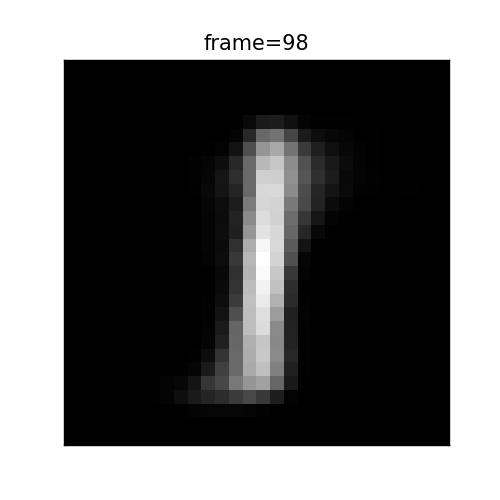

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST, FashionMNIST
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from matplotlib import animation, rc
#import VAE_pytorch
#import torch_dataset
from sklearn import preprocessing


BATCH_SIZE = 10



csv_indata = pd.read_csv('mnist10000.csv', encoding='ms932',header=None, sep=',')
img = csv_indata.iloc[:,1:].values
num = csv_indata.iloc[:,0].values.reshape(-1,1)
print(num)
mm = preprocessing.MinMaxScaler()
#texture_data = np.concatenate([texture_bow.values,gel_values,emul_values],axis=1)
img = mm.fit_transform(img)
img_size=len(img[0])




# pytorchを使ったVAE 以下の記事で、numpyのmnistから、pytorch　dataset に変換するように修正
# https://qiita.com/gensal/items/613d04b5ff50b6413aa0
# 特徴量は必ずscalingすること
#td = torch_dataset()
# pytorchのdatasetオブジェクトの作り方は以下
# return features_x, labels で特徴量と教師データの2種類をreturnしているが、以下のように、これらを内部に閉じ込めた１つ
# のdatasetオブジェクトを返すことに注意
# なお、教師データも縦ベクトル　num = digits.target.reshape(-1,1)　でないとエラーになる
# 
# https://dreamer-uma.com/pytorch-dataset/
# https://qiita.com/mathlive/items/2a512831878b8018db02

# いったんpytorch datasetオブジェクトが出来上がれば、あとはそのままdataloaderに放り込むだけ
# https://ohke.hateblo.jp/entry/2019/12/28/230000

trainval_data = create(img,num)
features_sample, label_sample = trainval_data[0]

'''
trainval_data = MNIST("./data", 
                   train=True, 
                   download=True, 
                   transform=transforms.ToTensor())
'''
#X_sample, y_sample = trainval_data[0]
#print(X_sample, y_sample)

train_size = int(len(trainval_data) * 0.8)
val_size = len(trainval_data)-train_size
train_data, val_data = torch.utils.data.random_split(trainval_data, [train_size, val_size])
#print(train_data[0].shape)
train_loader = DataLoader(dataset=train_data,
                          batch_size=BATCH_SIZE,
                          shuffle=True,drop_last=True,
                          num_workers=0)

val_loader = DataLoader(dataset=val_data,
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        num_workers=0)


def criterion(predict, target, ave, log_dev):
  bce_loss = F.binary_cross_entropy(predict, target, reduction='sum')
  kl_loss = -0.5 * torch.sum(1 + log_dev - ave**2 - log_dev.exp())
  loss = bce_loss + kl_loss
  return loss




num_epochs = 5
z_dim =2
in_out_dim = img_size
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
model = VAE(in_out_dim,z_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15], gamma=0.1)

history = {"train_loss": [], "val_loss": [], "ave": [], "log_dev": [], "z": [], "labels":[]}

for epoch in range(num_epochs):
  model.train()
  for i, (x, labels) in enumerate(train_loader):
    
    
    indata = x.to(device).view(-1, img_size).to(torch.float32)
    output, z, ave, log_dev = model(indata)

    history["ave"].append(ave)
    history["log_dev"].append(log_dev)
    history["z"].append(z)
    history["labels"].append(labels)
    
    loss = criterion(output, indata, ave, log_dev)
     
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
     
    if (i+1) % 50 == 0:
       print(f'Epoch: {epoch+1}, loss: {loss: 0.4f}')
    history["train_loss"].append(loss)

  model.eval()
  with torch.no_grad():
    for i, (x, labels) in enumerate(val_loader):
      indata = x.to(device).view(-1, img_size).to(torch.float32)
      output, z, ave, log_dev = model(indata)

      loss = criterion(output, indata, ave, log_dev)
      history["val_loss"].append(loss)
      
    #print(f'Epoch: {epoch+1}, val_loss: {loss: 0.4f}')
  
  scheduler.step()


train_loss_tensor = torch.stack(history["train_loss"])
train_loss_np = train_loss_tensor.to('cpu').detach().numpy().copy()


# historyはリスト型の中に、batch毎のtorch tensorデータが入っているので、stackでリスト型でなくて、
# 全体をtorch tensorにする　stackでは次元数は維持される
ave_tensor = torch.stack(history["ave"])
log_var_tensor = torch.stack(history["log_dev"])
z_tensor = torch.stack(history["z"])
labels_tensor = torch.stack(history["labels"])

# torch.size() はnp.shapeと同じ
# 9600 というのは、全epochを動かした後、何個のバッチを生成したかを表す数(history["ave"].append(ave) のようにバッチ毎に結果をappendしている)


ave_np = ave_tensor.to('cpu').detach().numpy().copy()
log_var_np = log_var_tensor.to('cpu').detach().numpy().copy()
z_np = z_tensor.to('cpu').detach().numpy().copy()
labels_np = labels_tensor.to('cpu').detach().numpy().copy()


model.to("cpu")
batch_num = 500
label = 0

#labels_np = labels_np.reshape(labels_np.shape[0],labels_np.shape[1])

# np.mean内のスライシングは非常に洗練されたコーディング
# ave_np[batch_num:,:,0]と[labels_np[batch_num:,:,0] == label]は、処理が分離していることに注意
# まずve_np[batch_num:,:,0]で、1次元目が、batch_num 以降　かつ、3次元目が0列の配列を取り出す。これでスライシング後のnumpy配列が出来上がる
# 次に、スライシングしたnpから、[labels_np[batch_num:,:,0] == label]で条件抽出している。通常、a[a>10]のようにすると、要素が10以上のもので
# スライシング配列ができるが、基本的にこれと同じ考え方。ただし、条件記述部に、異なるnumpy配列を持ってくる。つまりa[b>10]のようなことをやっている
# a[]内の条件記述からは、Trueであるような要素indexが得られるので、実は、aとは異なるnumpy配列でもOK。だだし、bはaと同じ次元の配列でないと
# aの次元のインデックスと整合しなくなる。
# 更に、多次元の配列　[labels_np[batch_num:,:,0] で、==labelのように条件記述をすると、最後の次元の要素と、比較演算子 (== etc)を自動的に比較する
# ようになる。
# np.meanは、npの次元数にかかわらず全要素の平均を求めるので、結果としてスカラーがx_zero_meanに入る

# 以下、同じ処理の別解
'''
labels_np = labels_np.ravel()
label_index = np.where(labels_np[batch_num*BATCH_SIZE:] == label)
print(label_index)
ave_np=ave_np.reshape(-1,z_dim)[batch_num*BATCH_SIZE:,:]
x_zero_mean = np.mean(ave_np[label_index,0])
y_zero_mean = np.mean(ave_np[label_index,1])
print(x_zero_mean)
'''
label = 0
x_zero_mean = np.mean(ave_np[batch_num:,:,0][labels_np[batch_num:,:,0] == label])   #x軸の平均値
y_zero_mean = np.mean(ave_np[batch_num:,:,1][labels_np[batch_num:,:,0] == label])   #y軸の平均値
z_zero = torch.tensor([x_zero_mean,y_zero_mean], dtype = torch.float32)


label = 1
x_one_mean = np.mean(ave_np[batch_num:,:,0][labels_np[batch_num:,:,0] == label])   #x軸の平均値
y_one_mean = np.mean(ave_np[batch_num:,:,1][labels_np[batch_num:,:,0] == label])   #y軸の平均値
z_one = torch.tensor([x_one_mean,y_one_mean], dtype = torch.float32)


def plot(frame):
    plt.cla()
    z_zerotoone = ((99 - frame) * z_zero +  frame * z_one) / 99
    output = model.decoder(z_zerotoone)
    np_output = output.detach().numpy().copy()
    np_image = np.reshape(np_output, (28, 28))
    plt.imshow(np_image, cmap='gray')
    plt.xticks([]);plt.yticks([])
    plt.title("frame={}".format(frame))
    
%matplotlib notebook
#%matplotlib nbagg
fig = plt.figure(figsize=(4,4))
ani = animation.FuncAnimation(fig, plot, frames=99, interval=100)
rc('animation', html='jshtml')
ani
